# CIFAR 10 Residual network

In [0]:
%tensorflow_version 2.0 # Set tf2.0 version in Google Colab
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler
import os
import datetime
import time
import tensorboard
%load_ext tensorboard


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train = x_train / 255
#x_test = x_test / 255


y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

#x_train = x_train[:500]
#y_train = y_train[:500]


print("Tensorflow version: ",tf.__version__)
print(x_train.shape)


`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.0 # Set tf2.0 version in Google Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


Using TensorFlow backend.


170500096/170498071 [==============================] - 13s 0us/step
(50000, 10)
(10000, 10)
Tensorflow version:  2.1.0-rc1
(50000, 32, 32, 3)


# Training model with model.fit method

### callbacks

In [0]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, TensorBoard, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
from pylab import rcParams

logdir = 'logs/hparms'
chekpoints_dir = os.path.join('chekpoints', "ckpt_{epoch}")
batch_size = 125 # for having the rest to zero (50000 % 125 = 0)

# plot two separable plots of loss/accuracy model 
def history_model(history):
    plt.subplot(121)
    rcParams['figure.figsize'] = 13, 7
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('ResNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.ylim([0.0,1.0])
    plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')

    plt.subplot(122)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('ResNet loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.ylim([0.0,3.0])
    plt.legend(['train_loss', 'val_loss'])

    plt.show()


# defining the callbacks

def lr_schedule(epoch: int):
    lr = 0.1
    if epoch > 180 :
        lr = 0.001
    elif epoch > 90 :
        lr = 0.01
    return lr    
        
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1, update_freq='epoch', profile_batch = 100000000)  # log metrics
#Keras_callback =   # log hparams
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Save model after every 3 epochs (150000 / 50000)
checkpoint_callback = ModelCheckpoint(filepath = chekpoints_dir, save_freq='epoch', monitor='val_loss',save_best_only=True, verbose = 1)

class TrainCallback(Callback):

    def __init__(self, x_train, y_train):
        super().__init__()
        self.x_train = x_train
        self.y_train = y_train
    
    def on_epoch_begin(self, epoch, logs=None):
        print("<-----------------------------------------------       EPOCH {}     ----------------------------------------------->".format(epoch+1))
    
    def on_epoch_end(self, epoch, logs=None):
        (loss, acc) = self.model.evaluate(self.x_train, self.y_train, batch_size = 8192, verbose=0, callbacks=[checkpoint_callback])
        print(f"Real Loss on train : {loss}")
        print(f"Real Acc on train : {acc}")
    
    def on_test_begin(self, epoch, logs=None):
        print("\nCalculating the real train loss/accuracy ...")
    

# Let's try different architectures of Resnet

## Resnet with 3 blocks of 2 convolutions each one

In [0]:
from tensorflow.keras.layers import Input, Add, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop

def resnet_model():
    
    input = Input((32, 32,3), name="input")

    conv_0 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_0")(input)
    pool_0 = MaxPooling2D(pool_size=(2, 2), name='pool_0')(conv_0)

    conv_1 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_1")(pool_0)
    conv_2 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_2")(conv_1)
    output_1 = Add(name='add_1')([pool_0, conv_2])

    conv_3 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_3")(output_1)
    conv_4 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_4")(conv_3)
    output_2 = Add(name='add_2')([output_1, conv_4])

    conv_5 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_5")(output_2)
    conv_6 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_6")(conv_5)
    output_3 = Add(name='add_3')([output_2, conv_6])
    

    pooling = GlobalAveragePooling2D(name='globalAveragePooling2D')(output_3)

    flatten = Flatten(name="flatten")(pooling)
    fc_1 = Dense(128, activation='relu', name='fully_connected')(flatten)
    dropout = Dropout(0.2, name='dropout')(fc_1)    
    output = Dense(10, activation='softmax', name='output')(dropout)
    model = Model(input, output)
    
    return model
    
model = resnet_model()
plot_model(model, 'resnet2.png')

model.compile(
  optimizer=Adam(learning_rate=0.001),
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

hist = model.fit(x_train, y_train , epochs=150,
                 batch_size=256,
                 validation_data=(x_test, y_test),
                 callbacks=[checkpoint_callback])

history_model(hist.history)

### Resnet with 5 blocks of 2 convolutions each one

In [0]:
from tensorflow.keras.layers import Input, Add, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop

def resnet_model():
    
    input = Input((32, 32,3), name="input")

    conv_0 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_0")(input)
    pool_0 = MaxPooling2D(pool_size=(2, 2), name='pool_0')(conv_0)

    conv_1 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_1")(pool_0)
    conv_2 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_2")(conv_1)
    output_1 = Add(name='add_1')([pool_0, conv_2])

    conv_3 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_3")(output_1)
    conv_4 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_4")(conv_3)
    output_2 = Add(name='add_2')([output_1, conv_4])

    conv_5 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_5")(output_2)
    conv_6 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_6")(conv_5)
    output_3 = Add(name='add_3')([output_2, conv_6])

    conv_7 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_7")(output_3)
    conv_8 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_8")(conv_7)
    output_4 = Add(name='add_4')([output_3, conv_8])
    
    conv_9 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_9")(output_4)
    conv_10 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_10")(conv_9)
    output_5 = Add(name='add_5')([output_4, conv_10])

    pooling = GlobalAveragePooling2D(name='globalAveragePooling2D')(output_5)

    flatten = Flatten(name="flatten")(pooling)
    fc_1 = Dense(128, activation='relu', name='fully_connected')(flatten)
    dropout = Dropout(0.2, name='dropout')(fc_1)    
    output = Dense(10, activation='softmax', name='output')(dropout)
    model = Model(input, output)
    
    return model
    
model = resnet_model()
plot_model(model, 'resnet_with_5_blocks.png')

model.compile(
  optimizer=Adam(learning_rate=0.001),
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

hist = model.fit(x_train, y_train , epochs=100,
                 batch_size=256,
                 validation_data=(x_test, y_test),
                 callbacks=[checkpoint_callback])

history_model(hist.history)

# Adding dropout after each conv

In [0]:
from tensorflow.keras.layers import Input, Add, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop

def resnet_model():
    
    dropout_rate = 0.2

    input = Input((32, 32,3), name="input")

    conv_0 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_0")(input)
    pool_0 = MaxPooling2D(pool_size=(2, 2), name='pool_0')(conv_0)

    conv_1 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_1")(pool_0)
    dropout_1 = Dropout(dropout_rate, name='dropout_1')(conv_1)
    conv_2 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_2")(dropout_1)
    dropout_2 = Dropout(dropout_rate, name='dropout_2')(conv_2)
    output_1 = Add(name='add_1')([pool_0, dropout_2])

    conv_3 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_3")(output_1)
    dropout_3 = Dropout(dropout_rate, name='dropout_3')(conv_3)
    conv_4 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_4")(dropout_3)
    dropout_4 = Dropout(dropout_rate, name='dropout_4')(conv_4)
    output_2 = Add(name='add_2')([output_1, dropout_4])

    conv_5 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_5")(output_2)
    dropout_5 = Dropout(dropout_rate, name='dropout_5')(conv_5)
    conv_6 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_6")(dropout_5)
    dropout_6 = Dropout(dropout_rate, name='dropout_6')(conv_6)
    output_3 = Add(name='add_3')([output_2, dropout_6])

    conv_7 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_7")(output_3)
    dropout_7 = Dropout(dropout_rate, name='dropout_7')(conv_7)
    conv_8 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_8")(dropout_7)
    dropout_8 = Dropout(dropout_rate, name='dropout_8')(conv_8)
    output_4 = Add(name='add_4')([output_3, dropout_8])
    
    conv_9 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_9")(output_4)
    dropout_9 = Dropout(dropout_rate, name='dropout_9')(conv_9)
    conv_10 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_10")(dropout_9)
    dropout_10 = Dropout(dropout_rate, name='dropout_10')(conv_10)
    output_5 = Add(name='add_5')([output_4, dropout_10])

    pooling = GlobalAveragePooling2D(name='globalAveragePooling2D')(output_5)

    flatten = Flatten(name="flatten")(pooling)
    fc_1 = Dense(128, activation='relu', name='fully_connected')(flatten)
    dropout_fc = Dropout(dropout_rate, name='dropout_fc')(fc_1)    
    output = Dense(10, activation='softmax', name='output')(dropout_fc)
    model = Model(input, output)
    
    return model
    
model = resnet_model()
plot_model(model, 'resnet_with_5_blocks_dropout.png')

model.compile(
  optimizer=Adam(learning_rate=0.001),
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

hist = model.fit(x_train, y_train , epochs=150,
                 batch_size=256,
                 validation_data=(x_test, y_test))

history_model(hist.history)

Train on 50000 samples, validate on 10000 samples
Epoch 1/150
 5120/50000 [==>...........................] - ETA: 16s - loss: 30.7763 - acc: 0.1143

KeyboardInterrupt: ignored

## Adding a batch normalization within each block

Train on 50000 samples, validate on 10000 samples
<-----------------------------------------------       EPOCH 1     ----------------------------------------------->
Epoch 1/100
49920/50000 [============================>.] - ETA: 0s - loss: 2.2934 - acc: 0.1870
Calculating the real train loss/accuracy ...
Real Loss on train : 2.0613809702301027
Real Acc on train : 0.24412000179290771
50000/50000 [==============================] - 79s 2ms/sample - loss: 2.2931 - acc: 0.1869 - val_loss: 2.0609 - val_acc: 0.2492
<-----------------------------------------------       EPOCH 2     ----------------------------------------------->
Epoch 2/100
49920/50000 [============================>.] - ETA: 0s - loss: 2.0260 - acc: 0.2315
Calculating the real train loss/accuracy ...
Real Loss on train : 1.9501652044677735
Real Acc on train : 0.2856200039386749
50000/50000 [==============================] - 75s 1ms/sample - loss: 2.0260 - acc: 0.2316 - val_loss: 1.9532 - val_acc: 0.2848
<--------------------

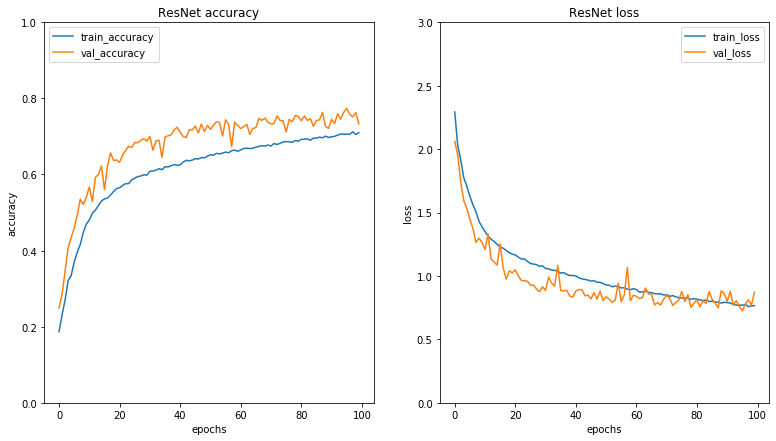

In [0]:
from tensorflow.keras.layers import Input, Add, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop

def resnet_model():
    
    dropout_rate = 0.2
    
    input = Input((32, 32,3), name="input")

    conv_0 = Conv2D(64, kernel_size=3,  strides=1, padding='SAME', name="conv_0")(input)
    batch_norm_0 = BatchNormalization(name='batch_norm_0')(conv_0)
    relu_0 = Activation('relu', name='relu_0')(batch_norm_0)

    # first block
    conv_1 = Conv2D(64, kernel_size=3,  strides=1, padding='SAME', name="conv_1")(relu_0)
    batch_norm_1 = BatchNormalization(name='batch_norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(batch_norm_1)
    dropout_1 = Dropout(dropout_rate, name='dropout_1')(relu_1)
    conv_2 = Conv2D(64, kernel_size=3,  strides=1, padding='SAME', name="conv_2")(dropout_1)
    batch_norm_2 = BatchNormalization(name='batch_norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(batch_norm_2)
    dropout_2 = Dropout(dropout_rate, name='dropout_2')(relu_2)

    output_1 = Add(name='add_1')([relu_0, dropout_2])
    
    # second block
    conv_3 = Conv2D(64, kernel_size=3,  strides=1, padding='SAME', name="conv_3")(output_1)
    batch_norm_3 = BatchNormalization(name='batch_norm_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(batch_norm_3)
    dropout_3 = Dropout(dropout_rate, name='dropout_3')(relu_3)
    conv_4 = Conv2D(64, kernel_size=3,  strides=1, padding='SAME', name="conv_4")(dropout_3)
    batch_norm_4 = BatchNormalization(name='batch_norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(batch_norm_4)
    dropout_4 = Dropout(dropout_rate, name='dropout_4')(relu_4)
    
    output_2 = Add(name='add_2')([output_1, dropout_4])

    # third block
    conv_5 = Conv2D(64, kernel_size=3,  strides=1, padding='SAME', name="conv_5")(output_2)
    batch_norm_5 = BatchNormalization(name='batch_norm_5')(conv_5)
    relu_5 = Activation('relu', name='relu_5')(batch_norm_5)
    dropout_5 = Dropout(dropout_rate, name='dropout_5')(relu_5)
    conv_6 = Conv2D(64, kernel_size=3,  strides=1, padding='SAME', name="conv_6")(dropout_5)
    batch_norm_6 = BatchNormalization(name='batch_norm_6')(conv_6)
    relu_6 = Activation('relu', name='relu_6')(batch_norm_6)
    dropout_6 = Dropout(dropout_rate, name='dropout_6')(relu_6)

    output_3 = Add(name='add_3')([output_2, dropout_6])
    
    # fourth block
    conv_7 = Conv2D(64, kernel_size=3,  strides=1, padding='SAME', name="conv_7")(output_3)
    batch_norm_7 = BatchNormalization(name='batch_norm_7')(conv_7)
    relu_7 = Activation('relu', name='relu_7')(batch_norm_7)
    dropout_7 = Dropout(dropout_rate, name='dropout_7')(relu_7)
    conv_8 = Conv2D(64, kernel_size=3,  strides=1, padding='SAME', name="conv_8")(dropout_7)
    batch_norm_8 = BatchNormalization(name='batch_norm_8')(conv_8)
    relu_8 = Activation('relu', name='relu_8')(batch_norm_8)
    dropout_8 = Dropout(dropout_rate, name='dropout_8')(relu_8)

    output_4 = Add(name='add_4')([output_3, dropout_8])


    # fifth block
    conv_9 = Conv2D(64, kernel_size=3,  strides=1, padding='SAME', name="conv_9")(output_4)
    batch_norm_9 = BatchNormalization(name='batch_norm_9')(conv_9)
    relu_9 = Activation('relu', name='relu_9')(batch_norm_9)
    dropout_9 = Dropout(dropout_rate, name='dropout_9')(relu_9)
    conv_10 = Conv2D(64, kernel_size=3,  strides=1, padding='SAME', name="conv_10")(dropout_9)
    batch_norm_10 = BatchNormalization(name='batch_norm_10')(conv_10)
    relu_10 = Activation('relu', name='relu_10')(batch_norm_10)
    dropout_10 = Dropout(dropout_rate, name='dropout_10')(relu_10)

    output_5 = Add(name='add_5')([output_4, dropout_10])


    pooling = AveragePooling2D(name='AveragePooling2D')(output_5)

    flatten = Flatten(name="flatten")(pooling)
    fc_1 = Dense(128, activation='relu', name='fully_connected')(flatten)
    dropout = Dropout(dropout_rate, name='dropout')(fc_1)    
    output = Dense(10, activation='softmax', name='output')(dropout)
    model = Model(input, output)
    
    return model
    
model = resnet_model()
plot_model(model, 'resnet_with_5_blocks_dropout_batchnorm_archi.png')

model.compile(
  optimizer=Adam(learning_rate=0.0001),
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

hist = model.fit(x_train, y_train , epochs=100,
                 batch_size=256,
                 validation_data=(x_test, y_test),
                 callbacks=[TrainCallback(x_train, y_train)])

history_model(hist.history)

## Adding L2 regularization of 0.0001

In [0]:
from tensorflow.keras.layers import Input, Add, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop

def resnet_model():
    
    dropout_rate = 0.3
    
    input = Input((32, 32,3), name="input")

    conv_0 = Conv2D(64, kernel_size=3,  strides=1, kernel_regularizer=l2(0.0001), padding='SAME', name="conv_0")(input)
    batch_norm_0 = BatchNormalization(name='batch_norm_0')(conv_0)
    relu_0 = Activation('relu', name='relu_0')(batch_norm_0)

    # first block
    conv_1 = Conv2D(64, kernel_size=3,  strides=1, kernel_regularizer=l2(0.0001), padding='SAME', name="conv_1")(relu_0)
    batch_norm_1 = BatchNormalization(name='batch_norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(batch_norm_1)
    dropout_1 = Dropout(dropout_rate, name='dropout_1')(relu_1)
    conv_2 = Conv2D(64, kernel_size=3,  strides=1, kernel_regularizer=l2(0.0001), padding='SAME', name="conv_2")(dropout_1)
    batch_norm_2 = BatchNormalization(name='batch_norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(batch_norm_2)
    dropout_2 = Dropout(dropout_rate, name='dropout_2')(relu_2)

    output_1 = Add(name='add_1')([relu_0, dropout_2])
    
    # second block
    conv_3 = Conv2D(64, kernel_size=3,  strides=1, kernel_regularizer=l2(0.0001), padding='SAME', name="conv_3")(output_1)
    batch_norm_3 = BatchNormalization(name='batch_norm_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(batch_norm_3)
    dropout_3 = Dropout(dropout_rate, name='dropout_3')(relu_3)
    conv_4 = Conv2D(64, kernel_size=3,  strides=1, kernel_regularizer=l2(0.0001), padding='SAME', name="conv_4")(dropout_3)
    batch_norm_4 = BatchNormalization(name='batch_norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(batch_norm_4)
    dropout_4 = Dropout(dropout_rate, name='dropout_4')(relu_4)
    
    output_2 = Add(name='add_2')([output_1, dropout_4])

    # third block
    conv_5 = Conv2D(64, kernel_size=3,  strides=1, kernel_regularizer=l2(0.0001), padding='SAME', name="conv_5")(output_2)
    batch_norm_5 = BatchNormalization(name='batch_norm_5')(conv_5)
    relu_5 = Activation('relu', name='relu_5')(batch_norm_5)
    dropout_5 = Dropout(dropout_rate, name='dropout_5')(relu_5)
    conv_6 = Conv2D(64, kernel_size=3,  strides=1, kernel_regularizer=l2(0.0001), padding='SAME', name="conv_6")(dropout_5)
    batch_norm_6 = BatchNormalization(name='batch_norm_6')(conv_6)
    relu_6 = Activation('relu', name='relu_6')(batch_norm_6)
    dropout_6 = Dropout(dropout_rate, name='dropout_6')(relu_6)

    output_3 = Add(name='add_3')([output_2, dropout_6])
    
    # fourth block
    conv_7 = Conv2D(64, kernel_size=3,  strides=1, kernel_regularizer=l2(0.0001), padding='SAME', name="conv_7")(output_3)
    batch_norm_7 = BatchNormalization(name='batch_norm_7')(conv_7)
    relu_7 = Activation('relu', name='relu_7')(batch_norm_7)
    dropout_7 = Dropout(dropout_rate, name='dropout_7')(relu_7)
    conv_8 = Conv2D(64, kernel_size=3,  strides=1, kernel_regularizer=l2(0.0001), padding='SAME', name="conv_8")(dropout_7)
    batch_norm_8 = BatchNormalization(name='batch_norm_8')(conv_8)
    relu_8 = Activation('relu', name='relu_8')(batch_norm_8)
    dropout_8 = Dropout(dropout_rate, name='dropout_8')(relu_8)

    output_4 = Add(name='add_4')([output_3, dropout_8])


    # fifth block
    conv_9 = Conv2D(64, kernel_size=3,  strides=1, kernel_regularizer=l2(0.0001), padding='SAME', name="conv_9")(output_4)
    batch_norm_9 = BatchNormalization(name='batch_norm_9')(conv_9)
    relu_9 = Activation('relu', name='relu_9')(batch_norm_9)
    dropout_9 = Dropout(dropout_rate, name='dropout_9')(relu_9)
    conv_10 = Conv2D(64, kernel_size=3,  strides=1, kernel_regularizer=l2(0.0001), padding='SAME', name="conv_10")(dropout_9)
    batch_norm_10 = BatchNormalization(name='batch_norm_10')(conv_10)
    relu_10 = Activation('relu', name='relu_10')(batch_norm_10)
    dropout_10 = Dropout(dropout_rate, name='dropout_10')(relu_10)

    output_5 = Add(name='add_5')([output_4, dropout_10])


    pooling = AveragePooling2D(name='AveragePooling2D')(output_5)

    flatten = Flatten(name="flatten")(pooling)
    fc_1 = Dense(128, activation='sigmoid', name='fully_connected')(flatten)
    dropout = Dropout(dropout_rate, name='dropout')(fc_1)    
    output = Dense(10, activation='softmax', name='output')(dropout)
    model = Model(input, output)
    
    return model
    
model = resnet_model()
plot_model(model, 'resnet_with_5_blocks_dropout_batchnorm_l2_archi.png')

model.compile(
  optimizer=Adam(learning_rate=0.0001),
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

hist = model.fit(x_train, y_train , epochs=100,
                 batch_size=256,
                 validation_data=(x_test, y_test),
                 callbacks=[TrainCallback(x_train, y_train)])

history_model(hist.history)

Train on 50000 samples, validate on 10000 samples
<-----------------------------------------------       EPOCH 1     ----------------------------------------------->
Epoch 1/100
49920/50000 [============================>.] - ETA: 0s - loss: 2.2957 - accuracy: 0.1883
Calculating the real train loss/accuracy ...
Real Loss on train : 1.9929041609954834
Real Acc on train : 0.3659600019454956
50000/50000 [==============================] - 67s 1ms/sample - loss: 2.2954 - accuracy: 0.1886 - val_loss: 1.9865 - val_accuracy: 0.3664
<-----------------------------------------------       EPOCH 2     ----------------------------------------------->
Epoch 2/100
49920/50000 [============================>.] - ETA: 0s - loss: 2.0363 - accuracy: 0.2944
Calculating the real train loss/accuracy ...
Real Loss on train : 1.8898927189254762
Real Acc on train : 0.3921400010585785
50000/50000 [==============================] - 65s 1ms/sample - loss: 2.0363 - accuracy: 0.2945 - val_loss: 1.8837 - val_accuracy:

# let's run some tests

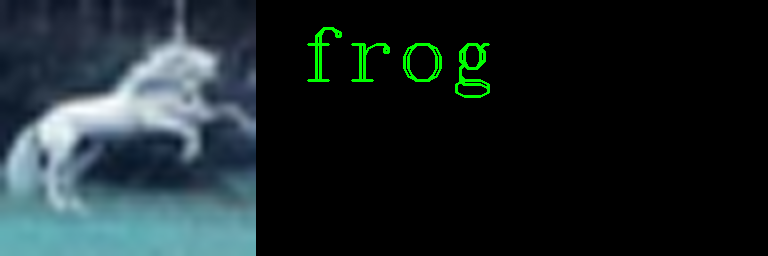

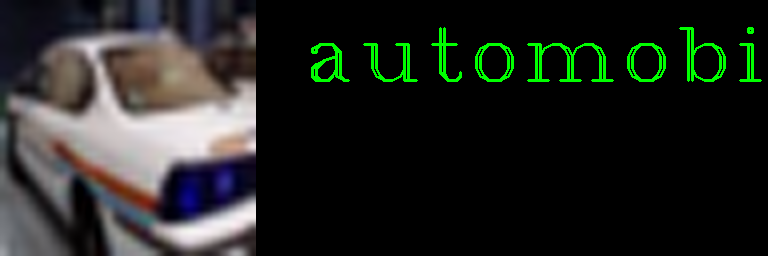

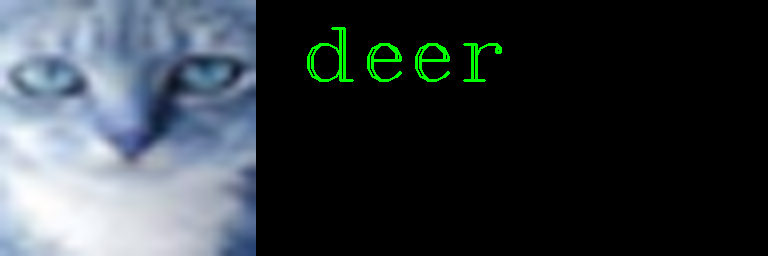

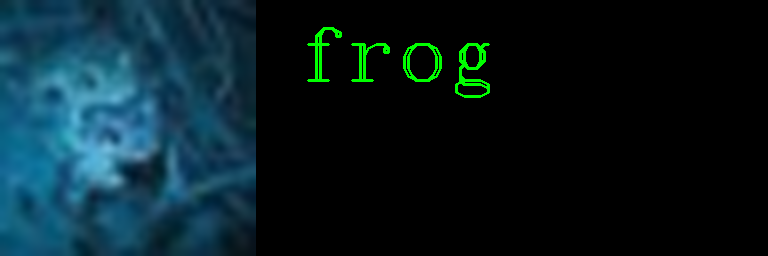

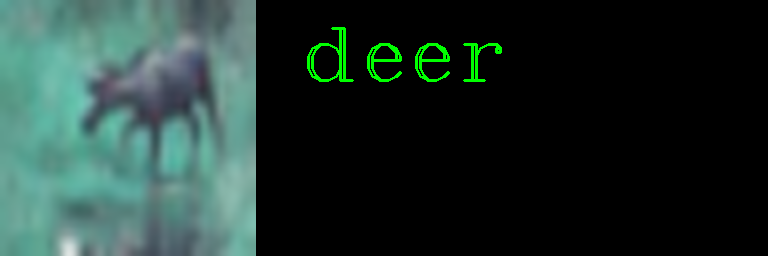

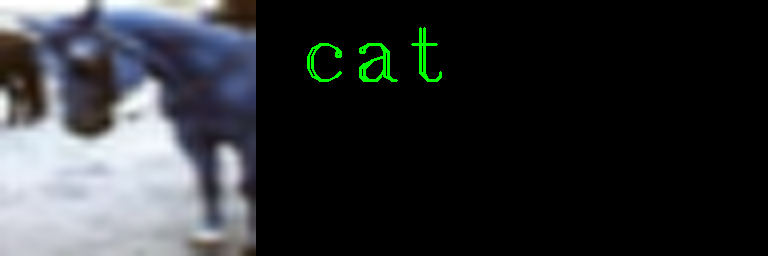

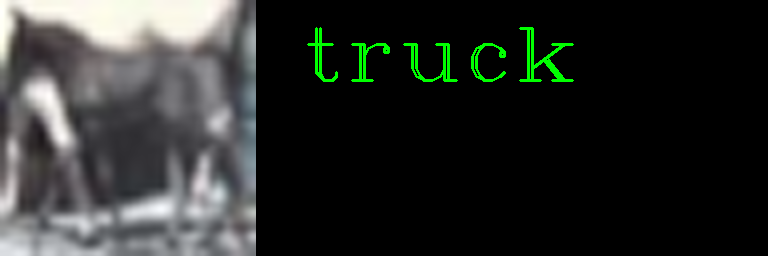

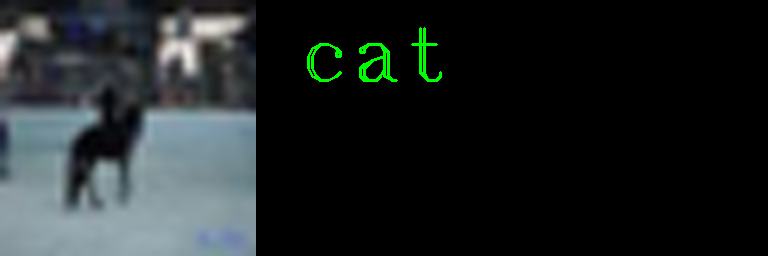

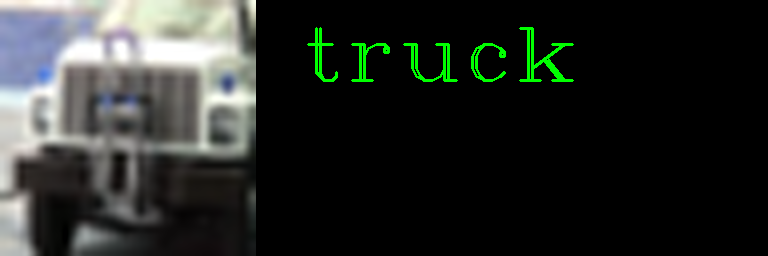

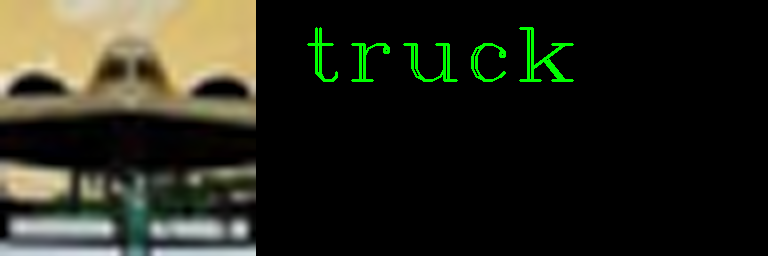

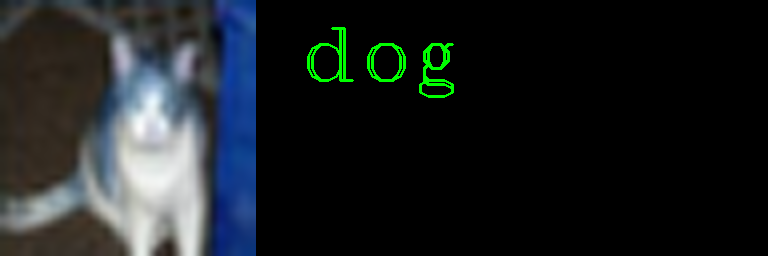

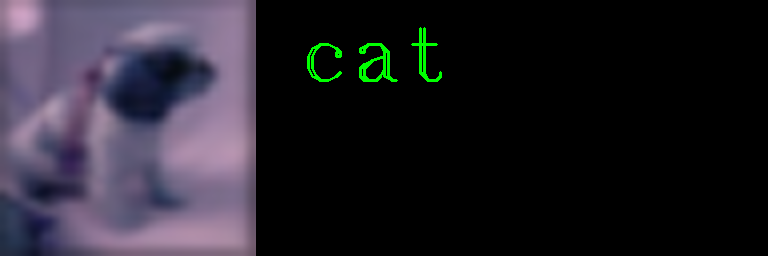

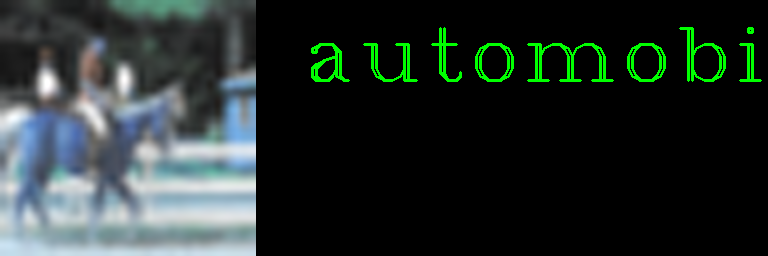

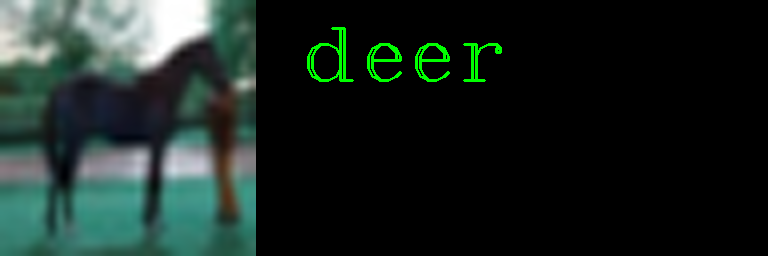

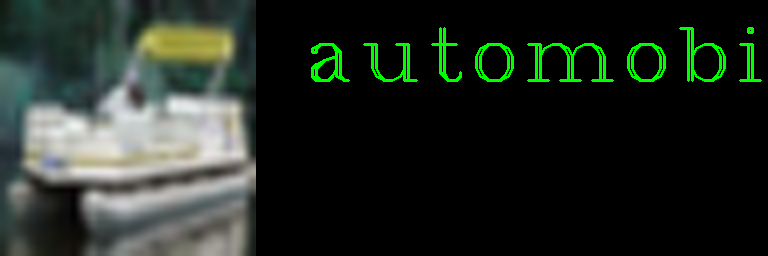

In [0]:
import cv2
import numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow

img_row, img_height, img_depth = 32,32,3
color = True
scale = 8

#model = model.load_weights(tf.train.latest_checkpoint('/content/chekpoints'))
#eval_loss, eval_acc = model.evaluate(x_test, y_test)
#print('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))

def draw_test(name, res, input_im, scale, img_row, img_height):
    BLACK = [0,0,0]
    res = int(res)
    if res == 0:
        pred = "airplane"
    if res == 1:
        pred = "automobile"
    if res == 2:
        pred = "bird"
    if res == 3:
        pred = "cat"
    if res == 4:
        pred = "deer"
    if res == 5:
        pred = "dog"
    if res == 6:
        pred = "frog"
    if res == 7:
        pred = "horse"
    if res == 8:
        pred = "ship"
    if res == 9:
        pred = "truck"
        
    expanded_image = cv2.copyMakeBorder(input_im, 0, 0, 0, imageL.shape[0]*2 ,cv2.BORDER_CONSTANT,value=BLACK)
    if color == False:
        expanded_image = cv2.cvtColor(expanded_image, cv2.COLOR_GRAY2BGR)
    cv2.putText(expanded_image, str(pred), (300, 80) , cv2.FONT_HERSHEY_COMPLEX_SMALL,4, (0,255,0), 2)
    cv2_imshow( expanded_image)
    #cv2.imshow(name, expanded_image)


for i in range(0,15):
    rand = np.random.randint(0,len(x_test))
    input_im = x_test[rand]
    imageL = cv2.resize(input_im, None, fx=scale, fy=scale, interpolation = cv2.INTER_CUBIC) 
    input_im = input_im.reshape(1,img_row, img_height, img_depth) 
    
    ## Get Prediction
    res = model.predict(input_im)
    res = np.where(res[0] == max(res[0]))[0][0]
    draw_test("Prediction", res, imageL, scale, img_row, img_height) 
    cv2.waitKey(0)

cv2.destroyAllWindows()